# Image and Multiple Bounding Boxes Augmentation for Deep Learning

## Problem at hand
Say we have images for training our Deep Neural Network. We also have separate PASCAL VOC format XML files with coordinates of bounding boxes for objects we are going to train our model to detect. 
We want to use [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).
To do so we are planning to:
1. Convert all XML files into one CSV file that we can feed into TensorFlow Object Detection API
2. Resize all images together with the corresponding object bounding boxes
3. Augment images to upsample our dataset. Corresponding object bounding boxes should be augmented accordingly
4. Document augmented images' new sizes and bounding boxes' coordinates to a CSV file

This tutorial will walk you through this process step by step.

## Solution

At the core of this tutorial we will use amazing [imgaug library](https://github.com/aleju/imgaug). Author has published [tutorials](https://nbviewer.jupyter.org/github/aleju/imgaug-doc/tree/master/notebooks/) on the use of the library and [Documentation](https://imgaug.readthedocs.io/en/latest/index.html) is available as well.

But here's a problem:
I had to spend a whole day digging through the Documentation and coding up the script for my problem.
I decided to share it, so you don't have to waste your time.

The easiest way to install imgaug is through Anaconda. Follow this steps in Anaconda prompt to create a virtual environment, install imgaug and activate the environment:
```
conda create -n myenv python=3.5.6
conda config --add channels conda-forge
conda install imgaug
conda activate myenv
```
You can refer to [imgaug library GitHub page](https://github.com/aleju/imgaug) for additional info on installation. To work through this tutorial you would need pandas installed as well. If you work through Anaconda it is installed by default.

In [1]:
# we will import all required libraries for this tutorial in advance

import imgaug as ia
ia.seed(1)
# imgaug uses matplotlib backend for displaying images
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
# imageio library will be used for image input/output
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil

## The data: images, XML files, bounding boxes

Let's have a look at data we have. You can see basic operations of imgaug library for image loading and augmentation in this [notebook](https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb).

In [2]:
# load images as NumPy arrays and append them to images list
images = []
for index, file in enumerate(glob.glob('testImages/*.jpg')):
    images.append(imageio.imread(file))
    
# how many images we have
print('We have {} images'.format(len(images)))

We have 5 images


In [3]:
# what are the sizes of the images
for index, file in enumerate(glob.glob('images/*.jpg')):
    print('Image {} have size of {}'.format(file[7:], images[index].shape))

Image ales-krivec-1Ofu8QGRFrg-unsplash.jpg have size of (1072, 1200, 3)
Image jim-bread-SBnxlHHrEwk-unsplash.jpg have size of (1200, 800, 3)
Image jim-bread-XW7CGOlNG40-unsplash.jpg have size of (400, 600, 3)
Image joshua-j-cotten-7JaeaeWQ8cE-unsplash.jpg have size of (1200, 800, 3)
Image natasha-ong-SQ3CZH_mKsM-unsplash.jpg have size of (800, 1200, 3)
Image rafael-garcin-UdLKOwwmA-o-unsplash.jpg have size of (450, 600, 3)
Image ritchie-valens-qZPzLJyiN7E-unsplash.jpg have size of (743, 1200, 3)
Image sonny-ravesteijn-N09f4fB92hI-unsplash.jpg have size of (400, 600, 3)
Image valentin-jorel-lftG-5nPTf8-unsplash.jpg have size of (800, 1200, 3)
Image valentin-petkov-loL9nnBK-fE-unsplash.jpg have size of (1200, 675, 3)


As you can see we have images of different sizes. Tuple of 3 numbers correspond to (width, height, channels). All our images are color images and consist of 3 channels RGB: red, green and blue.

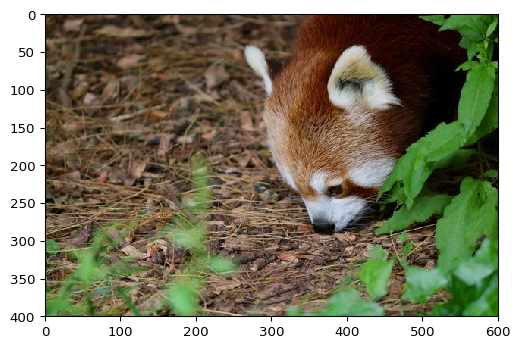

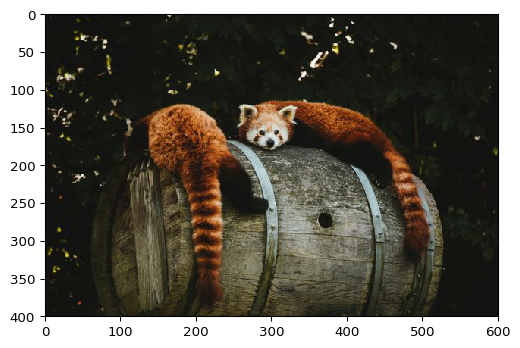

In [4]:
# Have a loook at 2 smaller images
ia.imshow(images[2])
ia.imshow(images[7])

All our images depict red pandas. Images are courtsey of Unsplash.com and their respective owners as described in image file names.

Now let's have a look at one of the XML files.

In [5]:
# XML file names correspond to the image file names
for index, file in enumerate(glob.glob('images/*.xml')):
    print(file[7:])

ales-krivec-1Ofu8QGRFrg-unsplash.xml
jim-bread-SBnxlHHrEwk-unsplash.xml
jim-bread-XW7CGOlNG40-unsplash.xml
joshua-j-cotten-7JaeaeWQ8cE-unsplash.xml
natasha-ong-SQ3CZH_mKsM-unsplash.xml
rafael-garcin-UdLKOwwmA-o-unsplash.xml
ritchie-valens-qZPzLJyiN7E-unsplash.xml
sonny-ravesteijn-N09f4fB92hI-unsplash.xml
valentin-jorel-lftG-5nPTf8-unsplash.xml
valentin-petkov-loL9nnBK-fE-unsplash.xml


In [6]:
# have a look how one of the XML annotation file looks like
# notice how it has 2 bounding boxes with red pandas
shutil.copy('images/sonny-ravesteijn-N09f4fB92hI-unsplash.xml', 'images/sonny-ravesteijn-N09f4fB92hI-unsplash.txt')
annotation_text = open("images/sonny-ravesteijn-N09f4fB92hI-unsplash.txt", "r")
print(annotation_text.read())
annotation_text.close() 

<annotation>
	<folder>images</folder>
	<filename>sonny-ravesteijn-N09f4fB92hI-unsplash.jpg</filename>
	<path>C:\Users\Asset\Documents\articles\image_bbs_augmentation\images\sonny-ravesteijn-N09f4fB92hI-unsplash.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>600</width>
		<height>400</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>red_panda</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>101</xmin>
			<ymin>118</ymin>
			<xmax>296</xmax>
			<ymax>387</ymax>
		</bndbox>
	</object>
	<object>
		<name>red_panda</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>252</xmin>
			<ymin>114</ymin>
			<xmax>510</xmax>
			<ymax>333</ymax>
		</bndbox>
	</object>
</annotation>



## 1. Convert all XML files into one CSV file that we can feed into TensorFlow Object Detection API

To convert all separate PASCAL VOC format XML files into one CSV file we will use the [xml_to_csv.py](https://github.com/datitran/raccoon_dataset/blob/master/xml_to_csv.py) code developed by Dan Tran.

In [7]:
# Function that will extract column data for our CSV file
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [8]:
# apply xml_to_csv() function to convert all XML files in images/ folder into labels.csv
labels_df = xml_to_csv('images/')
labels_df.to_csv(('labels.csv'), index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [9]:
# in previuos cell we also put all annotation in labels_df
# let's see what's inside
# each bounding box has a separate row
# 2 pictures have two red pandas in it
labels_df

filename  width  height      class  xmin  \
0        ales-krivec-1Ofu8QGRFrg-unsplash.jpg   1200    1072  red_panda   288   
1          jim-bread-SBnxlHHrEwk-unsplash.jpg    800    1200  red_panda     0   
2          jim-bread-XW7CGOlNG40-unsplash.jpg    600     400  red_panda   260   
3    joshua-j-cotten-7JaeaeWQ8cE-unsplash.jpg    800    1200  red_panda   359   
4        natasha-ong-SQ3CZH_mKsM-unsplash.jpg   1200     800  red_panda     0   
5      rafael-garcin-UdLKOwwmA-o-unsplash.jpg    600     450  red_panda   232   
6     ritchie-valens-qZPzLJyiN7E-unsplash.jpg   1200     743  red_panda   289   
7   sonny-ravesteijn-N09f4fB92hI-unsplash.jpg    600     400  red_panda   101   
8   sonny-ravesteijn-N09f4fB92hI-unsplash.jpg    600     400  red_panda   252   
9     valentin-jorel-lftG-5nPTf8-unsplash.jpg   1200     800  red_panda   450   
10   valentin-petkov-loL9nnBK-fE-unsplash.jpg    675    1200  red_panda    11   
11   valentin-petkov-loL9nnBK-fE-unsplash.jpg    675    1200  red_panda   386   

    ymin  xmax  ymax  
0    119   831   847  
1    251   609   797  
2      0   559   296  
3    347   635   847  
4    160   773   568  
5    185   568   423  
6    182   725   660  
7    118   296   387  
8    114   510   333  
9    206   900   589  
10   339   428   823  
11   528   675   842

## 2. Resize all images together with the corresponding object bounding boxes

TensorFlow Object Detection API can be fed by images of different sizes. But your GPU might not be able to handle big pictures. Let's say we want to resize all the picture so the width and height should be 600px or less. 

To get familiar with basics of image and multiple bounding boxes augmentation refer to this [tutorial](https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/B02%20-%20Augment%20Bounding%20Boxes.ipynb) from imgaug creators.

We will create resize_imgaug() function that will take DataFrame as shown in the previous cell and apply resizing augmentation to the image and all corresponding bounding boxes. The function will return DataFrame with updated images and bounding boxes annotations.

First, we visualize some of the operation that will take place in the resize_imgaug() function.

In [10]:
# start by groupping each image bounding boxes coordinates
# separate dataframes are formed based on the filename
grouped = labels_df.groupby('filename')

In [11]:
# we can pull each group with get_group() using the filename
group_df = grouped.get_group('valentin-petkov-loL9nnBK-fE-unsplash.jpg')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
group_df

filename  width  height      class  xmin  \
0  valentin-petkov-loL9nnBK-fE-unsplash.jpg    675    1200  red_panda    11   
1  valentin-petkov-loL9nnBK-fE-unsplash.jpg    675    1200  red_panda   386   

   ymin  xmax  ymax  
0   339   428   823  
1   528   675   842

### Visualization of bounding boxes

In [12]:
# get bounding boxes coordinates from grouped data frame and write into array        
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
# display the array we've got
bb_array

array([[ 11, 339, 428, 823],
       [386, 528, 675, 842]], dtype=int64)

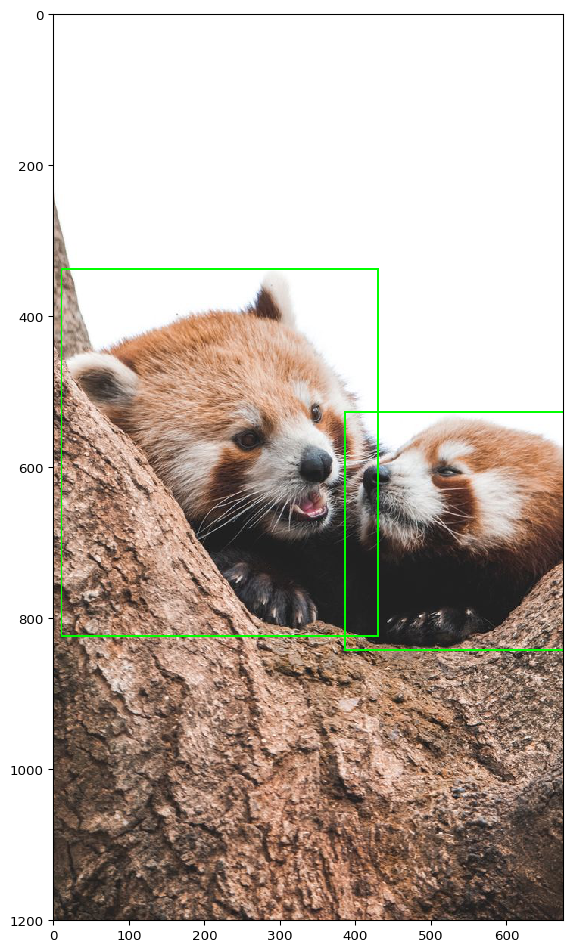

In [13]:
# pass the array of bounding boxes coordinates to the imgaug library
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=images[9].shape)
# display the image and draw bounding boxes
ia.imshow(bbs.draw_on_image(images[9], size=2))

In [14]:
# to resize the images we create two augmenters
# one is used when the image height is more than 600px and the other when the width is more than 600px
height_resize = iaa.Sequential([ 
    iaa.Resize({"height": 600, "width": 'keep-aspect-ratio'})
])

width_resize = iaa.Sequential([ 
    iaa.Resize({"height": 'keep-aspect-ratio', "width": 600})
])

When we augment images using imgaug library it resizes the bounding boxes as well and return BoundingBoxesOnImage object.
It looks like this: 
```
['filename.jpg',
 BoundingBoxesOnImage([BoundingBox(x1=81.1250, y1=114.5000, x2=324.8750, y2=320.7500, label=None)], shape=(337, 600, 3))]
```
bbs_obj_to_df() function will convert BoundingBoxesOnImage object to data frame with xmin, ymin, xmax, ymax columns.

In [15]:
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

Next, define resize_imgaug() function. 

It will take pandas DataFrame with ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'] columns. 

And apply resizing augmentation to the image and all corresponding bounding boxes. 

The function will return DataFrame with updated images and bounding boxes annotations.
resize_imgaug() function takes the following variables:
- df: pandas DataFrame with ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'] columns, labels_df in our case
- images_path: path to the folder with original images, 'images/' in our case(don't forget the forward slash)
- aug_images_path: path to the folder where augmented images will be stored, e.g. 'aug_images/' (the folder should be created in advance)
- image_prefix:  prefix for augmented image filenames, e.g 'aug_'

In [16]:
def resize_imgaug(df, images_path, aug_images_path, image_prefix):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')    
    
    for filename in df['filename'].unique():
    #   Get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)
        
    #   The only difference between if and elif statements below is the use of height_resize and width_resize augmentors
    #   deffined previously.

    #   If image height is greater than or equal to image width 
    #   AND greater than 600px perform resizing augmentation shrinking image height to 600px.
        if group_df['height'].unique()[0] >= group_df['width'].unique()[0] and group_df['height'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = height_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
            
    #   if image width is greater than image height 
    #   AND greater than 600px perform resizing augmentation shrinking image width to 600px
        elif group_df['width'].unique()[0] > group_df['height'].unique()[0] and group_df['width'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = width_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])

    #     append image info without any changes if it's height and width are both less than 600px 
        else:
            aug_bbs_xy = pd.concat([aug_bbs_xy, group_df])
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [17]:
# apply resizing augmentation to our images and write the updated images and bounding boxes annotations to the DataFrame 
# we will not apply prefix to our files and will overwrite images in the same directory
resized_images_df = resize_imgaug(labels_df, 'images/', 'images/', '')

In [18]:
# display new DataFrame
resized_images_df

filename width height      class  \
0        ales-krivec-1Ofu8QGRFrg-unsplash.jpg   600    536  red_panda   
1          jim-bread-SBnxlHHrEwk-unsplash.jpg   400    600  red_panda   
2          jim-bread-XW7CGOlNG40-unsplash.jpg   600    400  red_panda   
3    joshua-j-cotten-7JaeaeWQ8cE-unsplash.jpg   400    600  red_panda   
4        natasha-ong-SQ3CZH_mKsM-unsplash.jpg   600    400  red_panda   
5      rafael-garcin-UdLKOwwmA-o-unsplash.jpg   600    450  red_panda   
6     ritchie-valens-qZPzLJyiN7E-unsplash.jpg   600    372  red_panda   
7   sonny-ravesteijn-N09f4fB92hI-unsplash.jpg   600    400  red_panda   
8   sonny-ravesteijn-N09f4fB92hI-unsplash.jpg   600    400  red_panda   
9     valentin-jorel-lftG-5nPTf8-unsplash.jpg   600    400  red_panda   
10   valentin-petkov-loL9nnBK-fE-unsplash.jpg   338    600  red_panda   
11   valentin-petkov-loL9nnBK-fE-unsplash.jpg   338    600  red_panda   

          xmin        ymin        xmax        ymax  
0   144.000000   59.500000  415.500000  423.500000  
1     0.000000  125.500000  304.500000  398.500000  
2   260.000000    0.000000  559.000000  296.000000  
3   179.500000  173.500000  317.500000  423.500000  
4     0.000000   80.000000  386.500000  284.000000  
5   232.000000  185.000000  568.000000  423.000000  
6   144.500000   91.122475  362.500000  330.444153  
7   101.000000  118.000000  296.000000  387.000000  
8   252.000000  114.000000  510.000000  333.000000  
9   225.000000  103.000000  450.000000  294.500000  
10    5.508148  169.500000  214.317047  411.500000  
11  193.285919  264.000000  338.000000  421.000000

In [19]:
# overwrite the labels.csv with updated info
resized_images_df.to_csv('labels.csv', index=False)

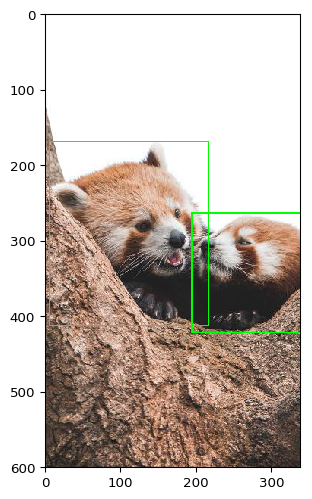

In [20]:
# visualise the resized valentin-petkov-loL9nnBK-fE-unsplash.jpg image with bounding boxes
# to make sure our bounding boxes were resized correctly as well
grouped = resized_images_df.groupby('filename')
group_df = grouped.get_group('valentin-petkov-loL9nnBK-fE-unsplash.jpg')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
image = imageio.imread('images/valentin-petkov-loL9nnBK-fE-unsplash.jpg')
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
ia.imshow(bbs.draw_on_image(image, size=2))

## 3. Augment images to upsample our dataset. Corresponding object bounding boxes should be augmented accordingly

In this part we will learn how to perform image augmetations. To do so we slightly change our resize_imgaug() function. But first, let's assign augmentation we want to perfom.

imgaug allows us to tune many cool parameters which you can read about in their [Documentation](https://imgaug.readthedocs.io/en/latest/source/augmenters.html).

In [21]:
# This setup of augmentation parameters will pick two of four given augmenters and apply them in random order
aug = iaa.SomeOf(2, [    
    iaa.Affine(scale=(0.5, 1.5)),
    iaa.Affine(rotate=(-60, 60)),
    iaa.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}),
    iaa.Fliplr(1),
    iaa.Multiply((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
])

Let's code image_aug() function.

It takes the same variables as resize_imgaug(), plus:
-augmenter: augmentation parameters of imgaug library. We can now apply custom augmenters.

image_aug() function is very similar to resize_imgaug().

But there's a caveat.

Augmentations, like zooming in and translating the image in x/y directions, can lead to objects of interest (e'g', red pandas) partially or completely move out of image pane. 

image_aug() function will clip the bounding box if the object of interest is partially outside of image pane. And it will ignore image altogether if no bounding boxes left in image pane.

In [22]:
def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
    #   read the image
        image = imageio.imread(images_path+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [23]:
# Apply augmentation to our images and save files into 'aug_images/' folder with 'aug1_' prefix.
# Write the updated images and bounding boxes annotations to the augmented_images_df dataframe.
augmented_images_df = image_aug(resized_images_df, 'images/', 'aug_images/', 'aug1_', aug)

In [24]:
# display new dataframe
augmented_images_df

filename width height      class  \
0        aug1_ales-krivec-1Ofu8QGRFrg-unsplash.jpg   600    536  red_panda   
1          aug1_jim-bread-SBnxlHHrEwk-unsplash.jpg   400    600  red_panda   
2          aug1_jim-bread-XW7CGOlNG40-unsplash.jpg   600    400  red_panda   
3    aug1_joshua-j-cotten-7JaeaeWQ8cE-unsplash.jpg   400    600  red_panda   
4        aug1_natasha-ong-SQ3CZH_mKsM-unsplash.jpg   600    400  red_panda   
5      aug1_rafael-garcin-UdLKOwwmA-o-unsplash.jpg   600    450  red_panda   
6     aug1_ritchie-valens-qZPzLJyiN7E-unsplash.jpg   600    372  red_panda   
7   aug1_sonny-ravesteijn-N09f4fB92hI-unsplash.jpg   600    400  red_panda   
8   aug1_sonny-ravesteijn-N09f4fB92hI-unsplash.jpg   600    400  red_panda   
9     aug1_valentin-jorel-lftG-5nPTf8-unsplash.jpg   600    400  red_panda   
10   aug1_valentin-petkov-loL9nnBK-fE-unsplash.jpg   338    600  red_panda   
11   aug1_valentin-petkov-loL9nnBK-fE-unsplash.jpg   338    600  red_panda   

          xmin        ymin        xmax        ymax  
0   106.000000    0.000000  377.500000  355.500000  
1    94.500000  125.500000  399.000000  398.500000  
2   292.667419    0.000000  600.000000  391.458099  
3    26.500000  163.500000  164.500000  413.500000  
4     0.000000   12.000000  296.500000  216.000000  
5     0.000000    4.327755  374.857697  411.192444  
6    48.160755   30.209217  445.054016  372.000000  
7   101.000000  118.000000  296.000000  387.000000  
8   252.000000  114.000000  510.000000  333.000000  
9    87.406097   63.506233  404.490021  333.379883  
10    0.000000  193.453552  288.137970  496.870270  
11  150.754761  135.809341  338.000000  340.590240

Here using techniques described above to compare original resized images and augmented copies. We will draw bounding boxes as well to make sure they were augmented correctly.

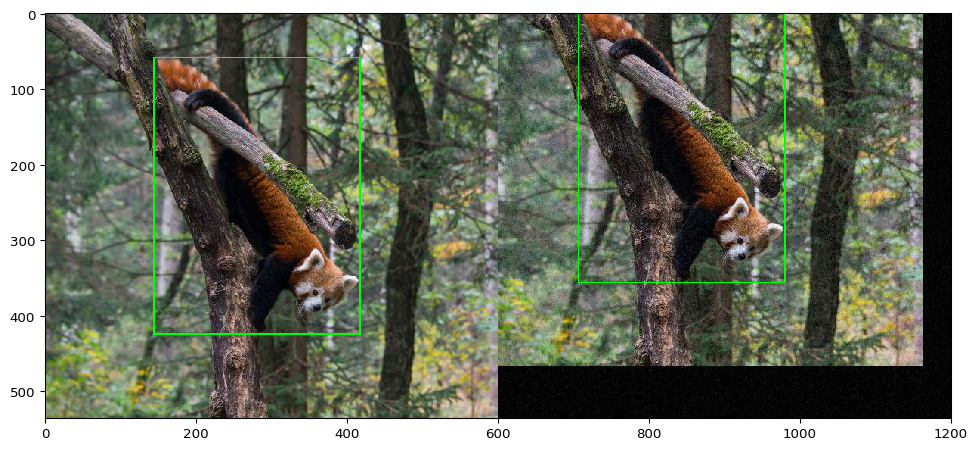

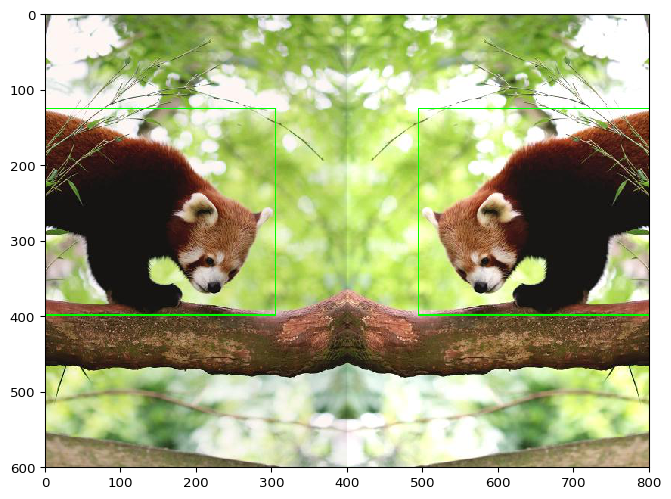

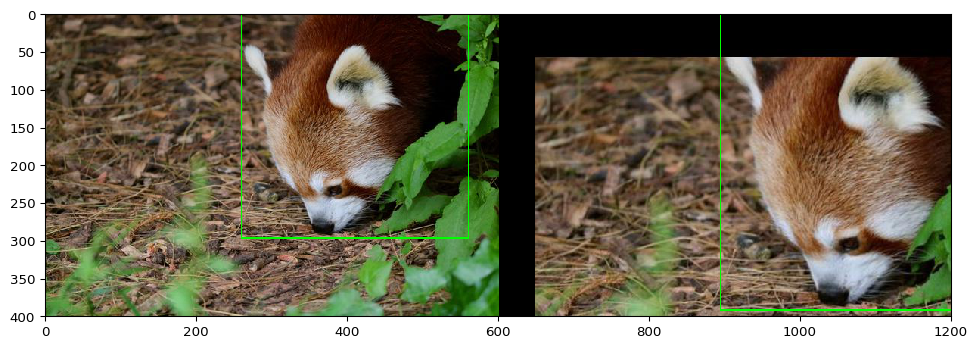

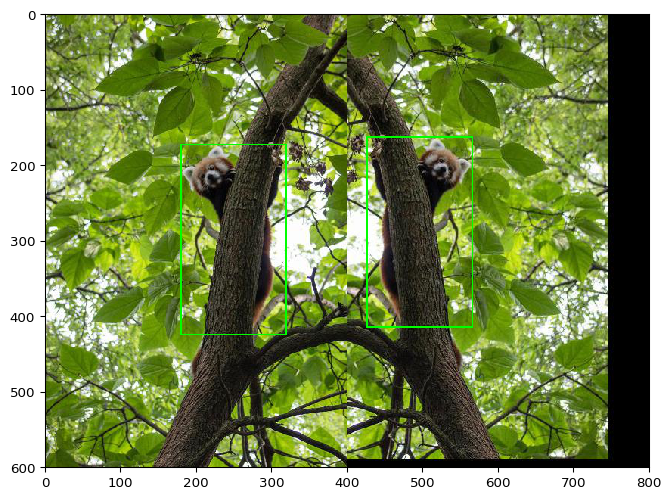

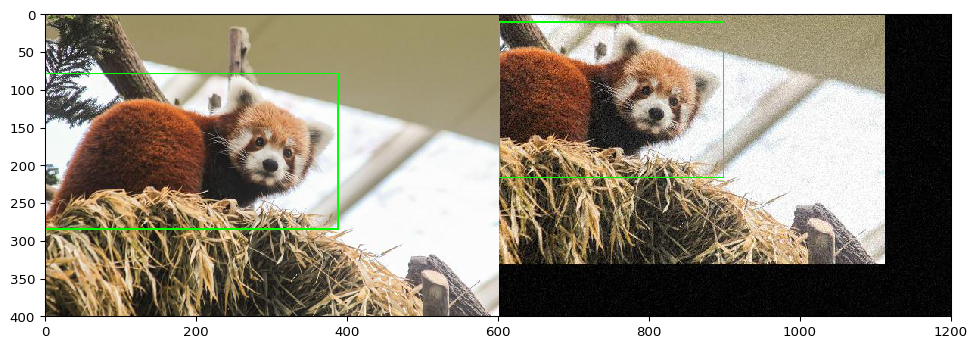

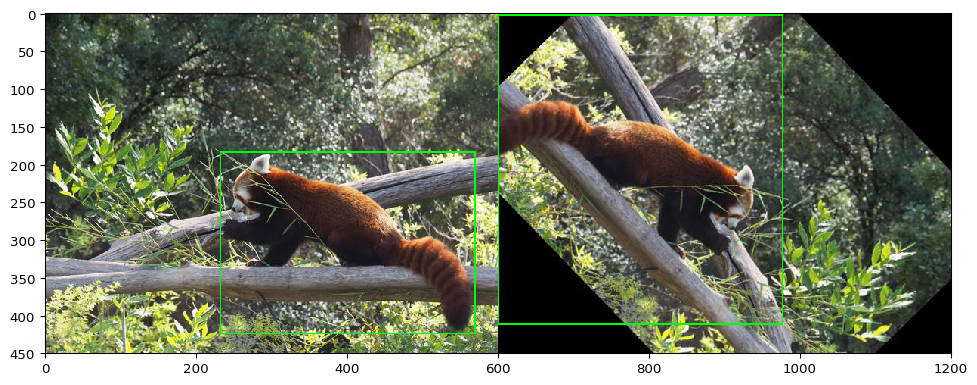

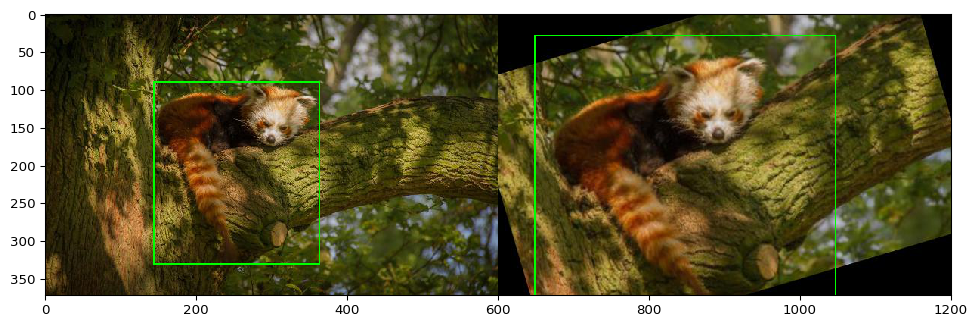

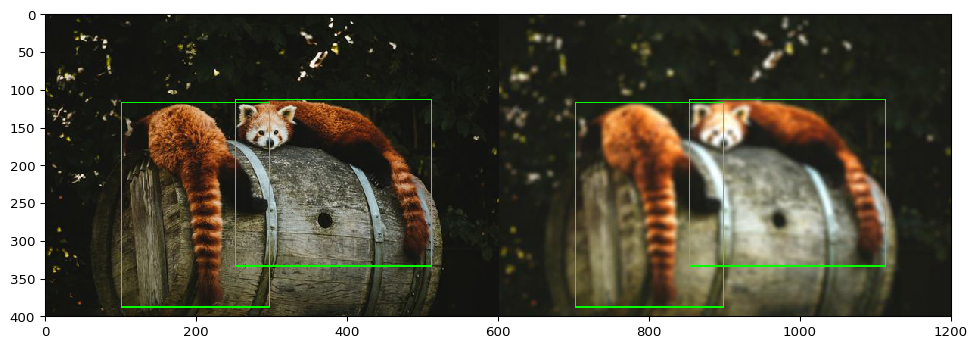

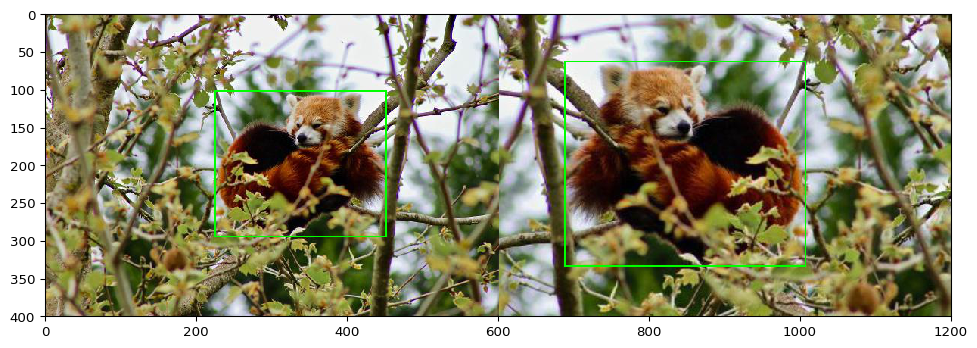

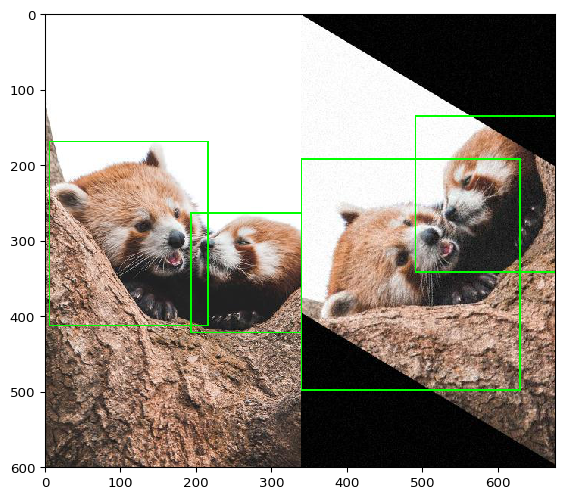

In [25]:
grouped_resized = resized_images_df.groupby('filename')
grouped_augmented = augmented_images_df.groupby('filename')

for filename in resized_images_df['filename'].unique():    
    
    group_r_df = grouped_resized.get_group(filename)
    group_r_df = group_r_df.reset_index()
    group_r_df = group_r_df.drop(['index'], axis=1)
    bb_r_array = group_r_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    resized_img = imageio.imread('images/'+filename)
    bbs_r = BoundingBoxesOnImage.from_xyxy_array(bb_r_array, shape=resized_img.shape)
    
    group_a_df = grouped_augmented.get_group('aug1_'+filename)
    group_a_df = group_a_df.reset_index()
    group_a_df = group_a_df.drop(['index'], axis=1)
    bb_a_array = group_a_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    augmented_img = imageio.imread('aug_images/'+'aug1_'+filename)
    bbs_a = BoundingBoxesOnImage.from_xyxy_array(bb_a_array, shape=augmented_img.shape)
    
    ia.imshow(np.hstack([
            bbs_r.draw_on_image(resized_img, size=2),
            bbs_a.draw_on_image(augmented_img, size=2)
            ]))

## 4. Document augmented images' new sizes and bounding boxes' coordinates to a CSV file

We have two pandas DataFrames: 
1. resized_images_df - original resized images annotations
2. augmented_images_df - augmented images annotations

Let's concat them together and save in a new all_labels.csv file. After that we can put all the images in one folder.

In [26]:
# Concat resized_images_df and augmented_images_df together and save in a new all_labels.csv file
all_labels_df = pd.concat([resized_images_df, augmented_images_df])
all_labels_df.to_csv('all_labels.csv', index=False)

In [27]:
# Lastly we can copy all our augmented images in the same folder as original resized images
for file in os.listdir('aug_images'):
    shutil.copy('aug_images/'+file, 'images/'+file)